In [75]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from arch import arch_model

def load_the_data(tiker):

    if not os.path.exists(f"{tiker}.csv"):
        data = yf.download(tiker, start="2018-01-01", end="2023-12-31")
        data.to_csv(f"{tiker}.csv")

    data = pd.read_csv(f"{tiker}.csv", index_col=0)
    data.index = pd.to_datetime(data.index, utc=True).tz_convert('US/Eastern')

    return data

Skewness: -0.5069182770564983
Kurtosis: 12.7514230300427


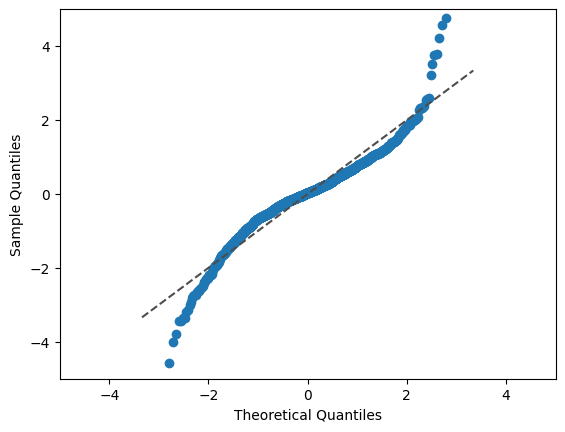

NormalDist: VaR at 1%: -0.0299
Historical: VaR at 1%: -0.0356


In [76]:
ticker = "^GSPC"

df = load_the_data(ticker)

returns = df['Close'].pct_change().fillna(0)
returns_std = returns.rolling(66).std().fillna(0)

# Find the skewness and the kurtosis of the returns
skew = returns.skew()
kurtosis = returns.kurtosis()

print(f"Skewness: {skew}")
print(f"Kurtosis: {kurtosis}")

# Plot the QQ plot of the returns
fig = plt.figure()
ax = fig.add_subplot(111)
fig = sm.qqplot(returns, ax=ax, fit=True)

# Plot a 45 degree line
ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c=".3")

#Make the ylim and xlim the same
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)

plt.show()

# Find the VaR based on the normal distribution at 1%
VaR_normal = returns.mean() - 2.33 * returns.std()
print(f"NormalDist: VaR at 1%: {VaR_normal:.4f}")

# Find the VaR of the returns using the historical method at 1%
VaR = returns.quantile(0.01)
print(f"Historical: VaR at 1%: {VaR:.4f}")

In [77]:
# Fit a GARCH(1,1) model to the returns
model = arch_model(returns, vol='Garch', p=1, q=1)
model_fit = model.fit(disp='off')

print(model_fit.summary())

# Get the parameters of the model
omega, alpha, beta = model_fit.params.values[1:]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                4802.34
Distribution:                  Normal   AIC:                          -9596.68
Method:            Maximum Likelihood   BIC:                          -9575.40
                                        No. Observations:                 1509
Date:                Fri, Apr 19 2024   Df Residuals:                     1508
Time:                        11:20:29   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         9.6277e-04  2.086e-04      4.616  3.909e-06 [5.

/home/vahid/.local/lib/python3.10/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001693. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


FHS VaR at 1%: -0.0238


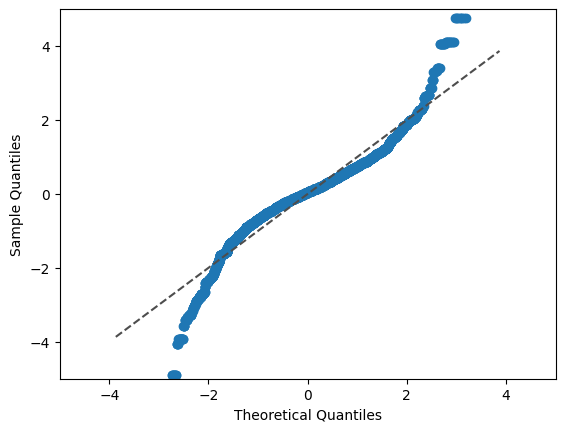

In [78]:
# Find the historical z-scores
standardized_returns = returns / returns.rolling(252).std()
standardized_returns = standardized_returns.dropna()

# Find the standard deviation of the returns for the next day
next_day_std = (omega + alpha * returns.iloc[-1]**2 + beta * returns_std.iloc[-1]**2)**0.5

# Randomly select 5000 standardized returns from the historical z-scores
random_selection = np.random.choice(standardized_returns, 10000)

# Forecasts of the returns
forecasts = next_day_std * random_selection

# Construct the QQ plot of the forecasted returns
fig = plt.figure()
ax = fig.add_subplot(111)
fig = sm.qqplot(forecasts, ax=ax, fit=True)

# Plot a 45 degree line
ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c=".3")

#Make the ylim and xlim the same
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)

# Find the value at risk at the 1% level
VaR = np.percentile(forecasts, 1)
print (f"FHS VaR at 1%: {VaR:.4f}")